# Discovery
Come primo punto fondamentale è quello di indagare cosa stiamo cercando all'interno del dataset e il perchè.

Negli ultimi anni l'opinione pubblica e l'attenzione mediatica si sono spostate sul movimento attivista di Black Lifes Matter, il quale lotta contro il razzismo, perpetuato a livello socio-politico, verso le persone nere.

Black Lives Matter organizza regolarmente delle manifestazioni per protestare apertamente contro gli omicidi delle persone nere da parte della polizia, nonché contro questioni più estese come profilazione razziale, brutalità della polizia e disuguaglianza razziale nel sistema giuridico degli Stati Uniti.

Da questo dataset vogliamo ottenere uteriori informazioni riguardo la presenza o meno di correnti razziste all'interno dei gruppi di polizia americane e la loro affidabilità.

## Problemi
Tramite questa analisi si vuole indagare i rapporti delle forze di polizia con le varie etnie della nazione.

## Obiettivi
Trovare, se esistono, dei pattern all'interno dei dati che possano spiegare determinati comportamenti da parte della polizia.


# Data Selection
I file di cui faremo utilizzo saranno contenuti nell cartella "./AndreaScottiDataVis".

In particolare ritengo che tutti i file se adeguatamente manipolati possano fornire una visione d'insieme utile a comprendere meglio il fenomeno.

L'idea principale è quella di studiare se e come i diversi elementi siano correlati tra di loro, in particolacre da un punto di vista macroscopico, perciò analizzeremo i vari fenomeni divisi per stato piuttosto che per singola città.


#  Data Cleaning & Trasformation
Importiamo i file e rimuoviamo i dati non rilevanti allo studio.

In [1]:
import pandas as pd
from pandas.io.html import read_html
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
from itertools import combinations
import folium.plugins as plugins
from datetime import datetime, timedelta
import requests

sns.set_style("darkgrid")

In [2]:
df = pd.read_csv("./AndreaScottiDataVis/fatal-police-shootings-data.csv")
#Droppa le colonne con questi nomi poichè poco rilevanti
df = df.drop(columns={"id", "name", "city", "longitude", "latitude"})
df

date   manner_of_death         armed   age gender race state  \
0     2015-01-02              shot           gun  53.0      M    A    WA   
1     2015-01-02              shot           gun  47.0      M    W    OR   
2     2015-01-03  shot and Tasered       unarmed  23.0      M    H    KS   
3     2015-01-04              shot    toy weapon  32.0      M    W    CA   
4     2015-01-04              shot      nail gun  39.0      M    H    CO   
...          ...               ...           ...   ...    ...  ...   ...   
7446  2022-06-05              shot         knife   NaN      M  NaN    FL   
7447  2022-06-06              shot           gun  73.0      M  NaN    FL   
7448  2022-06-07              shot  undetermined  20.0      M  NaN    OH   
7449  2022-06-08              shot         knife   NaN    NaN  NaN    WI   
7450  2022-06-08              shot           gun  45.0      M  NaN    IA   

      signs_of_mental_illness  threat_level         flee  body_camera  \
0                        True        attack  Not fleeing        False   
1                       False        attack  Not fleeing        False   
2                       False         other  Not fleeing        False   
3                        True        attack  Not fleeing        False   
4                       False        attack  Not fleeing        False   
...                       ...           ...          ...          ...   
7446                    False         other  Not fleeing        False   
7447                    False        attack          NaN         True   
7448                    False  undetermined          NaN         True   
7449                    False         other          NaN        False   
7450                    False        attack          NaN        False   

      is_geocoding_exact  
0                   True  
1                   True  
2                   True  
3                   True  
4                   True  
...                  ...  
7446                True  
7447                True  
7448                True  
7449                True  
7450                True  

[7451 rows x 12 columns]

In [3]:
#Droppa tutte le righe con razza o stato = NaN
df.dropna(axis="index", how="any", subset=["race", "state"], inplace=True)

In [4]:
#Filla le celle che non presentano un sesso
df["gender"].fillna("O", inplace=True)

In [5]:
#Converto i valori nella collonna "armati" con true o False
df.loc[df["armed"] == "unarmed", "armed"] = False
df.loc[df["armed"] != "unarmed", "armed"] = True
df["armed"] = df["armed"].astype("bool")

In [6]:
#Converto la colonna data in un corretto formato temporale
df["date"] = df["date"].astype("datetime64[ns]")

In [7]:
#Converto i valori nella collonna "flee" con true o False
df.loc[df["flee"] == "Not fleeing", "flee"] = False
df.loc[df["flee"] != "Foot", "flee"] = True
df.loc[df["flee"] != "Car", "flee"] = True
df["flee"] = df["flee"].astype("bool")

Convertiamo le colonne rimanenti

In [8]:
#Trasformo i valori delle restanti colonne in stringhe
ls = ["state", "manner_of_death", "gender", "threat_level", "race"]
for titles in ls:
    df[titles] = df[titles].astype("string")
df.dtypes

date                       datetime64[ns]
manner_of_death                    string
armed                                bool
age                               float64
gender                             string
race                               string
state                              string
signs_of_mental_illness              bool
threat_level                       string
flee                                 bool
body_camera                          bool
is_geocoding_exact                   bool
dtype: object

In [9]:
df.reset_index(drop=True, inplace=True)

In [10]:
#Riordino le colonne
titles = list(df.columns)
titles[1], titles[6], titles[2], titles[3] = titles[6], titles[1], titles[
    3], titles[2]
df = df[titles]

In [11]:
df

date state   age  armed gender race   manner_of_death  \
0    2015-01-02    WA  53.0   True      M    A              shot   
1    2015-01-02    OR  47.0   True      M    W              shot   
2    2015-01-03    KS  23.0   True      M    H  shot and Tasered   
3    2015-01-04    CA  32.0   True      M    W              shot   
4    2015-01-04    CO  39.0   True      M    H              shot   
...         ...   ...   ...    ...    ...  ...               ...   
6016 2022-05-19    CA  57.0   True      M    W              shot   
6017 2022-05-26    TX  48.0   True      M    W              shot   
6018 2022-05-26    TX  58.0   True      M    W              shot   
6019 2022-05-26    TX  48.0   True      M    W              shot   
6020 2022-05-29    MO  22.0   True      M    W              shot   

      signs_of_mental_illness threat_level  flee  body_camera  \
0                        True       attack  True        False   
1                       False       attack  True        False   
2                       False        other  True        False   
3                        True       attack  True        False   
4                       False       attack  True        False   
...                       ...          ...   ...          ...   
6016                    False        other  True         True   
6017                    False       attack  True        False   
6018                    False        other  True        False   
6019                    False       attack  True        False   
6020                    False       attack  True        False   

      is_geocoding_exact  
0                   True  
1                   True  
2                   True  
3                   True  
4                   True  
...                  ...  
6016                True  
6017                True  
6018                True  
6019                True  
6020                True  

[6021 rows x 12 columns]

In [12]:
# Creo una lista con i nomi dei vari stati
state_list = sorted(list(df["state"].unique()))
# Creo una lista di appoggio
df_state_list = []
# Aggiungo alla lista di appoggio ogni dataframe diviso per stato
for state in state_list:
    # assegno al valore "name" la copia del dataframe che ha i valori nella colonna "state" == al nome dello stato
    name = df[df["state"] == state].copy()
    # Rimuovo da ogni datadrame i valori in formato np.nan
    name.dropna(inplace=True)
    # Mi assicuro che non vi siano stringhe con il vare "nan" in nessuno dei dataframe
    for col in name.columns.unique():
        name.drop(name.index[name[col] == 'nan'], inplace=True)
    # Reimposto l'index
    name.reset_index(inplace=False, drop=True)
    # Aggiungo il dataframe alla lista di appoggio
    df_state_list.append(name)
df_state_list[0]

date state   age  armed gender race   manner_of_death  \
92   2015-02-08    AK  33.0   True      M    W              shot   
670  2015-09-08    AK  19.0   True      M    N              shot   
673  2015-09-09    AK  33.0   True      M    N              shot   
793  2015-10-24    AK  49.0   True      M    W              shot   
995  2016-01-12    AK  49.0   True      M    N              shot   
1076 2016-02-10    AK  36.0   True      M    N              shot   
1113 2016-02-21    AK  38.0   True      F    N              shot   
1374 2016-06-03    AK  33.0   True      M    W              shot   
1485 2016-07-12    AK  23.0   True      M    W              shot   
1600 2016-08-29    AK  28.0   True      M    N  shot and Tasered   
1777 2016-11-12    AK  40.0   True      M    W              shot   
2027 2017-02-17    AK  35.0   True      M    B              shot   
2123 2017-03-26    AK  36.0   True      M    W              shot   
2259 2017-05-25    AK  23.0   True      M    W              shot   
2321 2017-06-19    AK  21.0   True      M    N              shot   
2587 2017-10-01    AK  41.0   True      M    W              shot   
2705 2017-11-15    AK  48.0   True      M    W              shot   
2769 2017-12-24    AK  20.0   True      M    W              shot   
2975 2018-03-08    AK  27.0   True      M    N              shot   
3024 2018-03-24    AK  42.0   True      M    W              shot   
3025 2018-03-24    AK  20.0   True      M    N              shot   
3276 2018-06-29    AK  36.0   True      M    W              shot   
3294 2018-07-06    AK  38.0   True      M    A              shot   
3399 2018-08-16    AK  30.0   True      M    B              shot   
3594 2018-11-22    AK  20.0   True      M    W              shot   
3791 2019-02-13    AK  28.0   True      M    W              shot   
3845 2019-03-07    AK  23.0   True      M    W              shot   
3903 2019-03-31    AK  25.0   True      M    N              shot   
3906 2019-04-01    AK  31.0   True      M    B              shot   
4082 2019-06-16    AK  48.0   True      M    W              shot   
4550 2019-12-29    AK  34.0   True      M    W              shot   
4583 2020-01-07    AK  59.0   True      M    W              shot   
4625 2020-01-23    AK  26.0   True      M    W              shot   
4643 2020-01-29    AK  32.0   True      M    W              shot   
4683 2020-02-15    AK  16.0   True      M    A              shot   
4736 2020-03-08    AK  37.0   True      M    W              shot   
4741 2020-03-11    AK  32.0   True      F    W              shot   
5011 2020-06-23    AK  40.0   True      M    W              shot   
5287 2020-10-22    AK  43.0   True      M    W              shot   
5434 2020-12-20    AK  34.0   True      M    W              shot   
5607 2021-03-06    AK  27.0   True      M    W              shot   
5621 2021-03-13    AK  25.0   True      M    W              shot   
5798 2021-06-25    AK  23.0   True      M    W              shot   

      signs_of_mental_illness  threat_level  flee  body_camera  \
92                      False        attack  True        False   
670                     False        attack  True        False   
673                     False        attack  True        False   
793                     False        attack  True        False   
995                      True         other  True        False   
1076                    False        attack  True        False   
1113                    False        attack  True        False   
1374                    False         other  True        False   
1485                     True        attack  True        False   
1600                    False        attack  True         True   
1777                    False        attack  True        False   
2027                    False        attack  True        False   
2123                    False        attack  True        False   
2259                    False        attack  True        False   
2321                     Tru

In [13]:
# A questo punto creo una nuova lista di appoggio
states_values = []
# Introduco un ciclo for per avere un'indice che vada da 0 a 50 (coprendo tutti gli stati all'interno del file)
for idx in enumerate(state_list):
    # Creo il nome di ciascun dataframe composto dal prefisso "df_" e seguito dalle iniziali dello stato
    state = f"df_{idx[1]}"
    # Inizializzo il dataframe assegnandoli un'indice = idx (come abbiamo visto idx varia da 0 a 50)
    state = pd.DataFrame(index=[idx[0]])
    # Assegno il valore della colonna stato al secondo elemento di idx siccome idx si presenta come (numero, iniziali stato)
    state["state"] = idx[1]
    # Ora voglio assicurarmi che ogni df dei singoli stati presenti tutte le informazioni riguardanti
    # le sparatorie avvenute in esso, in particolare desidero ottenere le frequenze relative condizionate
    # a ciascuno stato per ogni possibile valore contenuto nelle colonne (escluse "age","date" e "state")
    for col in df_state_list[idx[0]].columns[3:11].unique():
        for val in df_state_list[idx[0]][col].unique():
            # assegno alla colonna rinominbata come "nome_colonna" + "valore all'interno della colonna"
            # la corrispettiva frequenza relativa condizionata allo stato
            state[f"{col}_{val}"] = df_state_list[idx[0]][col].value_counts(
                normalize=True)[val].round(2)
    # Aggiungo la collona dead per numerare quante persone sono morte per stato
    state["dead"] = df["state"].value_counts(ascending=True)[idx[1]]
    # Terminati i cicli for aggiungo alla lista di appoggio
    states_values.append(state)
    # Breve test per verificarne il funzionamento
states_values[0]

state  armed_True  gender_M  gender_F  race_W  race_N  race_B  race_A  \
0    AK         1.0      0.95      0.05    0.65    0.23    0.07    0.05   

   manner_of_death_shot  manner_of_death_shot and Tasered  \
0                  0.98                              0.02   

   signs_of_mental_illness_False  signs_of_mental_illness_True  \
0                           0.86                          0.14   

   threat_level_attack  threat_level_other  threat_level_undetermined  \
0                 0.72                0.26                       0.02   

   flee_True  body_camera_False  body_camera_True  dead  
0        1.0               0.91              0.09    43

In [14]:
# Unisco ognuno dei singoli 51 dataframe in uno e rimuovo i valori np.nan e li sostituisco con i valori 0
# poiche np.nan si verificano nelle casistiche in cui la frequenza relativa del particolare elemento è 0
df_states_shootings = pd.concat([states_values[0], states_values[1]])
for idx in enumerate(states_values):
    if idx[0] < (len(states_values) - 2):
        single_state = states_values[idx[0] + 2]
        df_states_shootings = pd.concat([df_states_shootings, single_state],
                                        ignore_index=True)

In [15]:
df_states_shootings = df_states_shootings.fillna(0)
#Rimuovo perchè poco significativi
ls = ["armed_True", "flee_True", "gender_O", "race_O"]
for titles in ls:
    df_states_shootings.drop([titles], axis=1, inplace=True)

df_states_shootings

state  gender_M  gender_F  race_W  race_N  race_B  race_A  \
0     AK      0.95      0.05    0.65    0.23    0.07    0.05   
1     AL      0.93      0.07    0.65    0.00    0.32    0.00   
2     AR      1.00      0.00    0.68    0.00    0.30    0.02   
3     AZ      0.93      0.07    0.49    0.05    0.08    0.00   
4     CA      0.95      0.05    0.31    0.00    0.19    0.04   
5     CO      0.96      0.04    0.56    0.02    0.10    0.02   
6     CT      1.00      0.00    0.43    0.00    0.24    0.00   
7     DC      0.83      0.17    0.11    0.00    0.89    0.00   
8     DE      0.92      0.08    0.46    0.00    0.46    0.00   
9     FL      0.94      0.06    0.49    0.00    0.35    0.00   
10    GA      0.92      0.07    0.47    0.00    0.45    0.01   
11    HI      0.94      0.06    0.09    0.00    0.06    0.38   
12    IA      0.92      0.08    0.79    0.00    0.21    0.00   
13    ID      0.94      0.06    0.83    0.02    0.02    0.02   
14    IL      0.96      0.04    0.30    0.00    0.57    0.00   
15    IN      0.97      0.03    0.66    0.00    0.30    0.00   
16    KS      0.93      0.07    0.67    0.02    0.15    0.00   
17    KY      0.96      0.04    0.79    0.01    0.17    0.01   
18    LA      0.98      0.02    0.40    0.00    0.56    0.02   
19    MA      1.00      0.00    0.56    0.00    0.21    0.00   
20    MD      0.96      0.04    0.30    0.00    0.65    0.01   
21    ME      0.96      0.04    0.88    0.00    0.04    0.00   
22    MI      0.97      0.03    0.61    0.00    0.35    0.01   
23    MN      0.97      0.03    0.61    0.06    0.21    0.04   
24    MO      0.93      0.07    0.58    0.00    0.39    0.01   
25    MS      0.96      0.04    0.58    0.00    0.39    0.01   
26    MT      0.97      0.03    0.86    0.14    0.00    0.00   
27    NC      0.97      0.03    0.61    0.01    0.33    0.01   
28    ND      1.00      0.00    0.46    0.54    0.00    0.00   
29    NE      0.94      0.06    0.67    0.03    0.18    0.00   
30    NH      1.00      0.00    1.00    0.00    0.00    0.00   
31    NJ      0.97      0.03    0.33    0.00    0.53    0.02   
32    NM      0.94      0.06    0.26    0.02    0.02    0.00   
33    NV      0.97      0.03    0.48    0.01    0.17    0.02   
34    NY      0.96      0.04    0.41    0.00    0.48    0.01   
35    OH      0.96      0.04    0.56    0.00    0.40    0.01   
36    OK      0.98      0.02    0.65    0.06    0.20    0.02   
37    OR      0.98      0.02    0.83    0.00    0.09    0.00   
38    PA      0.98      0.02    0.54    0.00    0.39    0.01   
39    RI      1.00      0.00    0.25    0.00    0.50    0.00   
40    SC      0.95      0.05    0.64    0.00    0.33    0.01   
41    SD      1.00      0.00    0.65    0.29    0.00    0.06   
42    TN      0.93      0.07    0.70    0.00    0.27    0.01   
43    TX      0.94      0.06    0.42    0.00    0.24    0.01   
44    UT      1.00      0.00    0.65    0.03    0.11    0.01   
45    VA      0.94      0.06    0.52    0.01    0.41    0.01   
46    VT      1.00      0.00    0.89    0.11    0.00    0.00   
47    WA      0.96      0.04    0.55    0.05    0.17    0.06   
48    WI      0.99      0.01    0.64    0.04    0.23    0.02   
49    WV      0.96      0.04    0.84    0.00    0.14    0.02   
50    WY      0.93      0.07    0.71    0.14    0.00    0.00   

    manner_of_death_shot  manner_of_death_shot and Tasered  \
0                   0.98                              0.02   
1                   0.93                              0.07   
2                   0.96                              0.04   
3                   0.96                              0.04   
4                   0.93                              0.07   
5                   0.98                              0.02   
6                   0.81                              0.19   
7                   1.00                              0.00   
8                   1.00                              0.00   
9                   0.95                              

In [16]:
df_states_shootings.describe().round(2)

gender_M  gender_F  race_W  race_N  race_B  race_A  \
count     51.00     51.00   51.00   51.00   51.00   51.00   
mean       0.96      0.04    0.57    0.04    0.25    0.02   
std        0.03      0.03    0.20    0.09    0.20    0.05   
min        0.83      0.00    0.09    0.00    0.00    0.00   
25%        0.94      0.02    0.46    0.00    0.10    0.00   
50%        0.96      0.04    0.58    0.00    0.21    0.01   
75%        0.98      0.06    0.67    0.02    0.39    0.02   
max        1.00      0.17    1.00    0.54    0.89    0.38   

       manner_of_death_shot  manner_of_death_shot and Tasered  \
count                 51.00                             51.00   
mean                   0.95                              0.05   
std                    0.04                              0.04   
min                    0.81                              0.00   
25%                    0.93                              0.02   
50%                    0.96                              0.04   
75%                    0.98                              0.07   
max                    1.00                              0.19   

       signs_of_mental_illness_False  signs_of_mental_illness_True  \
count                          51.00                         51.00   
mean                            0.76                          0.24   
std                             0.10                          0.10   
min                             0.44                          0.00   
25%                             0.72                          0.18   
50%                             0.77                          0.23   
75%                             0.82                          0.28   
max                             1.00                          0.56   

       threat_level_attack  threat_level_other  threat_level_undetermined  \
count                51.00               51.00                      51.00   
mean                  0.65                0.32                       0.03   
std                   0.10                0.09                       0.03   
min                   0.38                0.00                       0.00   
25%                   0.58                0.26                       0.01   
50%                   0.65                0.31                       0.03   
75%                   0.71                0.38                       0.04   
max                   1.00                0.50                       0.12   

       body_camera_False  body_camera_True    dead  race_H  
count              51.00             51.00   51.00   51.00  
mean                0.85              0.15  118.06    0.11  
std                 0.09              0.09  142.07    0.14  
min                 0.62              0.00    4.00    0.00  
25%                 0.82              0.09   37.50    0.02  
50%                 0.88              0.12   98.00    0.05  
75%                 0.91              0.18  125.00    0.15  
max                 1.00              0.38  852.00    0.71

##  Importo e pulisco i successivi 4 file

In questa sezione consideremo i primi 4 file della cartella, verranno puliti dai dati non necessari all'indagine e successivamente raggruppati in un unico dataframe.

In [17]:
# Costruisco una funzione per pulire i dataset
def clear_df(df_list):
    ls_clean = []
    for data in df_list:
        data = data.drop(columns={"City"})
        data.rename(columns={'Geographic Area': 'state'}, inplace=True)
        data.dropna(inplace=True)
        cols = list(data.columns)
        try:
            data.drop(data.index[data[cols[-1]].apply(
                lambda x: not (x.split(".")[0] + x.split(".")[-1]).isdigit())],
                      inplace=True)
        except AttributeError as e:
            # Questo errore si verifica perchè alcuni dati sono già float64
            print(e)
        data[cols[-1]] = data[cols[-1]].astype("float")
        data["state"] = data["state"].astype("string")
        data = data.groupby("state").mean().round(2)
        data.reset_index(inplace=True)
        ls_clean.append(data)
    return (list(ls_clean))

In [18]:
# Importo i file e all'occorrenza rimuovo le colonne non necessarie
df1 = pd.read_csv("./AndreaScottiDataVis/MedianHouseholdIncome2015.csv",
                  encoding='windows-1254')
df1.rename(columns={"Median Income": "median_household_income"}, inplace=True)
df2 = pd.read_csv(
    "./AndreaScottiDataVis/PercentagePeopleBelowPovertyLevel.csv",
    encoding='windows-1254')
df3 = pd.read_csv("./AndreaScottiDataVis/PercentOver25CompletedHighSchool.csv",
                  encoding='windows-1254')
df4 = pd.read_csv("./AndreaScottiDataVis/PopulationByCity.csv",
                  encoding='windows-1254')
df4.rename(columns={"city": "City"}, inplace=True)
df4.drop(columns={"lat", "lng"}, inplace=True)
ls = [df1, df2, df3, df4]

In [19]:
# Creo il dataset finale dei primi 4 stati
df_total = pd.DataFrame([])
# Introduco nel dataset la colonna degli stati
df_total["state"] = clear_df(ls)[0]["state"]
df_total["state"] = df_total["state"].astype("string")
# Popolo il dataset con le informazioni salienti
for idx in range(len(ls)):
    df_total[str(clear_df(ls)[idx].columns[-1])] = clear_df(ls)[idx][str(
        clear_df(ls)[idx].columns[-1])]
df_total

'float' object has no attribute 'split'
'float' object has no attribute 'split'
'float' object has no attribute 'split'
'float' object has no attribute 'split'
'float' object has no attribute 'split'
'float' object has no attribute 'split'
'float' object has no attribute 'split'
'float' object has no attribute 'split'
'float' object has no attribute 'split'
'float' object has no attribute 'split'
'float' object has no attribute 'split'
'float' object has no attribute 'split'
'float' object has no attribute 'split'


state  median_household_income  poverty_rate  percent_completed_hs  \
0     AK                 52099.59         19.85                 84.63   
1     AL                 40577.31         20.65                 80.30   
2     AR                 35593.41         22.96                 79.95   
3     AZ                 42495.67         25.67                 80.47   
4     CA                 62097.35         17.12                 81.96   
5     CO                 58857.70         13.36                 90.11   
6     CT                 75149.65          9.14                 91.59   
7     DC                 70848.00         18.00                 89.30   
8     DE                 61792.41         12.56                 88.52   
9     FL                 49811.31         17.57                 85.74   
10    GA                 39781.80         23.78                 79.01   
11    HI                 64708.74         13.40                 91.67   
12    IA                 48116.05         12.29                 90.11   
13    ID                 42484.79         18.24                 85.17   
14    IL                 54052.71         13.88                 88.48   
15    IN                 47713.01         15.50                 86.32   
16    KS                 44838.94         14.76                 88.23   
17    KY                 45683.31         20.08                 82.37   
18    LA                 41635.91         22.34                 79.29   
19    MA                 71765.91          9.59                 92.40   
20    MD                 78126.50         10.31                 88.42   
21    ME                 45397.47         16.89                 91.43   
22    MI                 44685.51         17.90                 89.21   
23    MN                 51678.66         13.75                 89.47   
24    MO                 41747.62         20.11                 83.52   
25    MS                 35002.10         26.88                 78.47   
26    MT                 45119.98         16.51                 90.49   
27    NC                 43302.34         19.75                 83.25   
28    ND                 52141.71         12.16                 87.82   
29    NE                 46582.91         12.98                 89.99   
30    NH                 54026.32         12.66                 90.71   
31    NJ                 80584.41          8.19                 90.85   
32    NM                 40952.91         23.08                 80.98   
33    NV                 57322.97         12.47                 87.72   
34    NY                 69890.67         11.67                 90.61   
35    OH                 50457.21         14.85                 88.34   
36    OK                 40447.29         20.66                 82.91   
37    OR                 48088.07         16.52                 88.30   
38    PA                 51758.77         12.52                 89.02   
39    RI                 64537.54         10.37                 88.82   
40    SC                 39787.09         22.16                 80.85   
41    SD                 45408.26         16.03                 87.75   
42    TN                 42249.77         19.89                 81.63   
43    TX                 51335.33         19.92                 75.69   
44    UT                 60216.37         11.98                 91.62   
45    VA                 61867.68         14.59                 84.88   
46    VT                 46284.78         13.79                 89.98   
47    WA                 59315.28         15.02                 88.20   
48    WI                 50411.40         12.86                 90.26   
49    WV                 39097.12         21.13                 82.35   
50    WY                 60874.99          9.89                 92.10   

    population  
0     22792.82  
1     38201.86  
2     28360.19  
3    126936.97  
4    148340.78  
5     92993.89  
6    148397.25  
7   5289420.00  
8     32778.22  
9    127544.46  
10    74510.93  
11

##  Importo e pulisco l'ultimo file

In [20]:
# Importo il file rimanente
df5 = pd.read_csv("./AndreaScottiDataVis/ShareRaceByCity.csv",
                  encoding='windows-1254')
df5.drop(columns={"City"}, inplace=True)
df5.rename(columns={"Geographic area": "state"}, inplace=True)

In [21]:
# Creo un loop per pulire i dati delle colonne inerenti alle razze
for races in df5.columns[1:5]:
    # Converto tutti i valori in stringe per poterli manipolare
    df5[races] = df5[races].astype("string")
    # Manipolo le stringhe per assicurarmi che se splittate e rigiuntate sia un numero e droppo quelle che non lo sono
    df5.drop(df5.index[df5[races].apply(
        lambda x: not (x.split(".")[0] + x.split(".")[-1]).isdigit())],
             inplace=True)
    # Reimposto i dati come float così da poter effettuare i calcoli
    df5[races] = df5[races].astype("float")

In [22]:
df5 = df5.groupby("state").mean().round(2)
df5.reset_index(drop=False, inplace=True)
df5

state  share_white  share_black  share_native_american  share_asian
0     AK        45.65         0.57                  45.86         1.39
1     AL        72.51        23.32                   0.66         0.48
2     AR        78.45        16.30                   0.76         0.48
3     AZ        59.93         0.95                  28.59         0.73
4     CA        71.87         2.69                   1.72         5.57
5     CO        87.77         0.92                   1.62         1.15
6     CT        86.11         4.99                   0.66         2.99
7     DC        38.50        50.70                   0.30         3.50
8     DE        76.25        15.39                   0.52         2.00
9     FL        78.67        13.37                   0.46         1.62
10    GA        62.59        30.63                   0.30         1.49
11    HI        33.37         1.07                   0.39        25.65
12    IA        96.71         0.56                   0.27         0.40
13    ID        88.82         0.30                   2.52         0.49
14    IL        90.36         4.70                   0.26         1.34
15    IN        94.82         1.69                   0.28         0.59
16    KS        92.96         0.96                   1.87         0.43
17    KY        92.23         4.42                   0.21         0.71
18    LA        64.81        30.78                   0.96         0.79
19    MA        89.67         2.80                   0.27         2.85
20    MD        72.12        19.46                   0.34         2.98
21    ME        95.69         0.82                   0.55         1.03
22    MI        90.67         4.12                   1.08         0.95
23    MN        91.80         1.00                   3.36         1.03
24    MO        90.44         5.88                   0.54         0.55
25    MS        53.80        41.83                   1.61         0.55
26    MT        84.48         0.23                  11.87         0.32
27    NC        71.52        20.40                   1.79         0.93
28    ND        92.29         0.36                   5.33         0.29
29    NE        94.72         0.42                   1.56         0.29
30    NH        95.68         0.72                   0.29         1.34
31    NJ        80.89         6.98                   0.26         5.94
32    NM        65.42         0.67                  15.34         0.49
33    NV        82.33         1.57                   5.58         2.01
34    NY        88.88         4.01                   0.36         2.72
35    OH        92.80         3.96                   0.22         0.75
36    OK        72.93         3.38                  14.38         0.43
37    OR        87.63         0.53                   2.59         1.38
38    PA        93.25         3.27                   0.16         0.99
39    RI        89.23         2.99                   0.67         1.69
40    SC        61.98        32.83                   0.46         0.74
41    SD        84.82         0.29                  12.03         0.32
42    TN        88.95         7.30                   0.32         0.64
43    TX        82.59         5.88                   0.66         1.01
44    UT        89.44         0.38                   3.87         0.77
45    VA        74.60        16.51                   0.34         3.67
46    VT        95.87         0.77                   0.37         0.91
47    WA        82.38         1.43                   3.75         3.07
48    WI        92.96         0.94                   2.62         0.79
49    WV        95.04         2.92                   0.20         0.34
50    WY        92.37         0.40                   3.10         0.39

## Unisco tutto nel df_total

In [23]:
for col in df5.columns:
    df_total[col] = df5[col]
df_total

state  median_household_income  poverty_rate  percent_completed_hs  \
0     AK                 52099.59         19.85                 84.63   
1     AL                 40577.31         20.65                 80.30   
2     AR                 35593.41         22.96                 79.95   
3     AZ                 42495.67         25.67                 80.47   
4     CA                 62097.35         17.12                 81.96   
5     CO                 58857.70         13.36                 90.11   
6     CT                 75149.65          9.14                 91.59   
7     DC                 70848.00         18.00                 89.30   
8     DE                 61792.41         12.56                 88.52   
9     FL                 49811.31         17.57                 85.74   
10    GA                 39781.80         23.78                 79.01   
11    HI                 64708.74         13.40                 91.67   
12    IA                 48116.05         12.29                 90.11   
13    ID                 42484.79         18.24                 85.17   
14    IL                 54052.71         13.88                 88.48   
15    IN                 47713.01         15.50                 86.32   
16    KS                 44838.94         14.76                 88.23   
17    KY                 45683.31         20.08                 82.37   
18    LA                 41635.91         22.34                 79.29   
19    MA                 71765.91          9.59                 92.40   
20    MD                 78126.50         10.31                 88.42   
21    ME                 45397.47         16.89                 91.43   
22    MI                 44685.51         17.90                 89.21   
23    MN                 51678.66         13.75                 89.47   
24    MO                 41747.62         20.11                 83.52   
25    MS                 35002.10         26.88                 78.47   
26    MT                 45119.98         16.51                 90.49   
27    NC                 43302.34         19.75                 83.25   
28    ND                 52141.71         12.16                 87.82   
29    NE                 46582.91         12.98                 89.99   
30    NH                 54026.32         12.66                 90.71   
31    NJ                 80584.41          8.19                 90.85   
32    NM                 40952.91         23.08                 80.98   
33    NV                 57322.97         12.47                 87.72   
34    NY                 69890.67         11.67                 90.61   
35    OH                 50457.21         14.85                 88.34   
36    OK                 40447.29         20.66                 82.91   
37    OR                 48088.07         16.52                 88.30   
38    PA                 51758.77         12.52                 89.02   
39    RI                 64537.54         10.37                 88.82   
40    SC                 39787.09         22.16                 80.85   
41    SD                 45408.26         16.03                 87.75   
42    TN                 42249.77         19.89                 81.63   
43    TX                 51335.33         19.92                 75.69   
44    UT                 60216.37         11.98                 91.62   
45    VA                 61867.68         14.59                 84.88   
46    VT                 46284.78         13.79                 89.98   
47    WA                 59315.28         15.02                 88.20   
48    WI                 50411.40         12.86                 90.26   
49    WV                 39097.12         21.13                 82.35   
50    WY                 60874.99          9.89                 92.10   

    population  share_white  share_black  share_native_american  share_asian  
0     22792.82        45.65         0.57                  45.86         1.39  
1     38201.86        72.51        23.32        

## Unisco df_total e df_states_shootings

In [24]:
# Uso la funzione merge per unire i due dataframes
df_all = pd.merge(df_total, df_states_shootings, on="state")
df_all

state  median_household_income  poverty_rate  percent_completed_hs  \
0     AK                 52099.59         19.85                 84.63   
1     AL                 40577.31         20.65                 80.30   
2     AR                 35593.41         22.96                 79.95   
3     AZ                 42495.67         25.67                 80.47   
4     CA                 62097.35         17.12                 81.96   
5     CO                 58857.70         13.36                 90.11   
6     CT                 75149.65          9.14                 91.59   
7     DC                 70848.00         18.00                 89.30   
8     DE                 61792.41         12.56                 88.52   
9     FL                 49811.31         17.57                 85.74   
10    GA                 39781.80         23.78                 79.01   
11    HI                 64708.74         13.40                 91.67   
12    IA                 48116.05         12.29                 90.11   
13    ID                 42484.79         18.24                 85.17   
14    IL                 54052.71         13.88                 88.48   
15    IN                 47713.01         15.50                 86.32   
16    KS                 44838.94         14.76                 88.23   
17    KY                 45683.31         20.08                 82.37   
18    LA                 41635.91         22.34                 79.29   
19    MA                 71765.91          9.59                 92.40   
20    MD                 78126.50         10.31                 88.42   
21    ME                 45397.47         16.89                 91.43   
22    MI                 44685.51         17.90                 89.21   
23    MN                 51678.66         13.75                 89.47   
24    MO                 41747.62         20.11                 83.52   
25    MS                 35002.10         26.88                 78.47   
26    MT                 45119.98         16.51                 90.49   
27    NC                 43302.34         19.75                 83.25   
28    ND                 52141.71         12.16                 87.82   
29    NE                 46582.91         12.98                 89.99   
30    NH                 54026.32         12.66                 90.71   
31    NJ                 80584.41          8.19                 90.85   
32    NM                 40952.91         23.08                 80.98   
33    NV                 57322.97         12.47                 87.72   
34    NY                 69890.67         11.67                 90.61   
35    OH                 50457.21         14.85                 88.34   
36    OK                 40447.29         20.66                 82.91   
37    OR                 48088.07         16.52                 88.30   
38    PA                 51758.77         12.52                 89.02   
39    RI                 64537.54         10.37                 88.82   
40    SC                 39787.09         22.16                 80.85   
41    SD                 45408.26         16.03                 87.75   
42    TN                 42249.77         19.89                 81.63   
43    TX                 51335.33         19.92                 75.69   
44    UT                 60216.37         11.98                 91.62   
45    VA                 61867.68         14.59                 84.88   
46    VT                 46284.78         13.79                 89.98   
47    WA                 59315.28         15.02                 88.20   
48    WI                 50411.40         12.86                 90.26   
49    WV                 39097.12         21.13                 82.35   
50    WY                 60874.99          9.89                 92.10   

    population  share_white  share_black  share_native_american  share_asian  \
0     22792.82        45.65         0.57                  45.86         1.39   
1     38201.86        72.51        23.32      

##  Pulizia json file e ultimi ritocchi

Ora è arrivata la parte di rappresentazione grafica

In [25]:
# Aggiungo una colonna al dataframe finale con il nome intero dello stato
page = "https://simple.wikipedia.org/wiki/List_of_U.S._states_by_traditional_abbreviation"
wikipage = read_html(page, attrs={"class": "wikitable"})
wikipage[0].drop(columns="Traditionalabbreviation", inplace=True)
wikipage[0].sort_values(by="Otherabbreviations")
wikipage[0].rename(columns={
    "State": "state_full_name",
    "Otherabbreviations": "state"
},
                   inplace=True)
wikipage[0]

state_full_name state
0                Alabama    AL
1                 Alaska    AK
2                Arizona    AZ
3               Arkansas    AR
4             California    CA
5               Colorado    CO
6            Connecticut    CT
7               Delaware    DE
8   District of Columbia    DC
9                Florida    FL
10               Georgia    GA
11                Hawaii    HI
12                 Idaho    ID
13              Illinois    IL
14               Indiana    IN
15                  Iowa    IA
16                Kansas    KS
17              Kentucky    KY
18             Louisiana    LA
19                 Maine    ME
20              Maryland    MD
21         Massachusetts    MA
22              Michigan    MI
23             Minnesota    MN
24           Mississippi    MS
25              Missouri    MO
26               Montana    MT
27              Nebraska    NE
28                Nevada    NV
29         New Hampshire    NH
30            New Jersey    NJ
31            New Mexico    NM
32              New York    NY
33        North Carolina    NC
34          North Dakota    ND
35                  Ohio    OH
36              Oklahoma    OK
37                Oregon    OR
38          Pennsylvania    PA
39          Rhode Island    RI
40        South Carolina    SC
41          South Dakota    SD
42             Tennessee    TN
43                 Texas    TX
44                  Utah    UT
45               Vermont    VT
46              Virginia    VA
47            Washington    WA
48         West Virginia    WV
49             Wisconsin    WI
50               Wyoming    WY

In [26]:
df_all = pd.merge(df_all, wikipage[0], on="state")
df_all

state  median_household_income  poverty_rate  percent_completed_hs  \
0     AK                 52099.59         19.85                 84.63   
1     AL                 40577.31         20.65                 80.30   
2     AR                 35593.41         22.96                 79.95   
3     AZ                 42495.67         25.67                 80.47   
4     CA                 62097.35         17.12                 81.96   
5     CO                 58857.70         13.36                 90.11   
6     CT                 75149.65          9.14                 91.59   
7     DC                 70848.00         18.00                 89.30   
8     DE                 61792.41         12.56                 88.52   
9     FL                 49811.31         17.57                 85.74   
10    GA                 39781.80         23.78                 79.01   
11    HI                 64708.74         13.40                 91.67   
12    IA                 48116.05         12.29                 90.11   
13    ID                 42484.79         18.24                 85.17   
14    IL                 54052.71         13.88                 88.48   
15    IN                 47713.01         15.50                 86.32   
16    KS                 44838.94         14.76                 88.23   
17    KY                 45683.31         20.08                 82.37   
18    LA                 41635.91         22.34                 79.29   
19    MA                 71765.91          9.59                 92.40   
20    MD                 78126.50         10.31                 88.42   
21    ME                 45397.47         16.89                 91.43   
22    MI                 44685.51         17.90                 89.21   
23    MN                 51678.66         13.75                 89.47   
24    MO                 41747.62         20.11                 83.52   
25    MS                 35002.10         26.88                 78.47   
26    MT                 45119.98         16.51                 90.49   
27    NC                 43302.34         19.75                 83.25   
28    ND                 52141.71         12.16                 87.82   
29    NE                 46582.91         12.98                 89.99   
30    NH                 54026.32         12.66                 90.71   
31    NJ                 80584.41          8.19                 90.85   
32    NM                 40952.91         23.08                 80.98   
33    NV                 57322.97         12.47                 87.72   
34    NY                 69890.67         11.67                 90.61   
35    OH                 50457.21         14.85                 88.34   
36    OK                 40447.29         20.66                 82.91   
37    OR                 48088.07         16.52                 88.30   
38    PA                 51758.77         12.52                 89.02   
39    RI                 64537.54         10.37                 88.82   
40    SC                 39787.09         22.16                 80.85   
41    SD                 45408.26         16.03                 87.75   
42    TN                 42249.77         19.89                 81.63   
43    TX                 51335.33         19.92                 75.69   
44    UT                 60216.37         11.98                 91.62   
45    VA                 61867.68         14.59                 84.88   
46    VT                 46284.78         13.79                 89.98   
47    WA                 59315.28         15.02                 88.20   
48    WI                 50411.40         12.86                 90.26   
49    WV                 39097.12         21.13                 82.35   
50    WY                 60874.99          9.89                 92.10   

    population  share_white  share_black  share_native_american  share_asian  \
0     22792.82        45.65         0.57                  45.86         1.39   
1     38201.86        72.51        23.32      

In [27]:
# Importo da github un file un dict di un file GeoJson degli stati uniti
# Questo passaggio serve a rappresentare graficamente i dati divisi per stato
geojson_url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
response = requests.get(geojson_url)
geojson = response.json()
print(len(geojson["features"]))
geojson

52


{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'id': '01',
   'properties': {'name': 'Alabama', 'density': 94.65},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-87.359296, 35.00118],
      [-85.606675, 34.984749],
      [-85.431413, 34.124869],
      [-85.184951, 32.859696],
      [-85.069935, 32.580372],
      [-84.960397, 32.421541],
      [-85.004212, 32.322956],
      [-84.889196, 32.262709],
      [-85.058981, 32.13674],
      [-85.053504, 32.01077],
      [-85.141136, 31.840985],
      [-85.042551, 31.539753],
      [-85.113751, 31.27686],
      [-85.004212, 31.003013],
      [-85.497137, 30.997536],
      [-87.600282, 30.997536],
      [-87.633143, 30.86609],
      [-87.408589, 30.674397],
      [-87.446927, 30.510088],
      [-87.37025, 30.427934],
      [-87.518128, 30.280057],
      [-87.655051, 30.247195],
      [-87.90699, 30.411504],
      [-87.934375, 30.657966],
      [-88.011052, 30.685351],
      [-88.10416, 30.499135],
      [-88.137022

In [28]:
# Creo una lista in cui aggiungo i nomi di tutti gli stati di cui si hanno informazioni per tracciare
# il loro contorno sulla cartina
x = 0
geojson_states = []
while x < len(geojson["features"]):
    geojson_states.append([geojson["features"][x]["properties"]["name"], x])
    x = x + 1
geojson_states = sorted(geojson_states)
geojson_states

[['Alabama', 0],
 ['Alaska', 1],
 ['Arizona', 2],
 ['Arkansas', 3],
 ['California', 4],
 ['Colorado', 5],
 ['Connecticut', 6],
 ['Delaware', 7],
 ['District of Columbia', 8],
 ['Florida', 9],
 ['Georgia', 10],
 ['Hawaii', 11],
 ['Idaho', 12],
 ['Illinois', 13],
 ['Indiana', 14],
 ['Iowa', 15],
 ['Kansas', 16],
 ['Kentucky', 17],
 ['Louisiana', 18],
 ['Maine', 19],
 ['Maryland', 20],
 ['Massachusetts', 21],
 ['Michigan', 22],
 ['Minnesota', 23],
 ['Mississippi', 24],
 ['Missouri', 25],
 ['Montana', 26],
 ['Nebraska', 27],
 ['Nevada', 28],
 ['New Hampshire', 29],
 ['New Jersey', 30],
 ['New Mexico', 31],
 ['New York', 32],
 ['North Carolina', 33],
 ['North Dakota', 34],
 ['Ohio', 35],
 ['Oklahoma', 36],
 ['Oregon', 37],
 ['Pennsylvania', 38],
 ['Puerto Rico', 51],
 ['Rhode Island', 39],
 ['South Carolina', 40],
 ['South Dakota', 41],
 ['Tennessee', 42],
 ['Texas', 43],
 ['Utah', 44],
 ['Vermont', 45],
 ['Virginia', 46],
 ['Washington', 47],
 ['West Virginia', 48],
 ['Wisconsin', 49],
 ['

In [29]:
# Metto a confronto la lista precedente con la lista degli stati di cui disponiamo i dati
states_to_drop = []
for states, idx in geojson_states:
    if not states in sorted(list(df_all["state_full_name"].unique())):
        states_to_drop.append([states, idx])
# Questa lista rappresentra gli stati di cui non abbiamo informazioni e che andrebbero rimossi dal file
# GeoJson
states_to_drop

[['Puerto Rico', 51]]

In [30]:
# Rimuovo dal dizionario lo stato di cui non abbiamo dati
for states, idx in states_to_drop:
    del geojson["features"][idx]
# Possiamo notare che infatti siamo passati da 52 stati a 51
print(len(geojson["features"]))

51


In [31]:
# Ho aggiunto al file GeoJson le diverse caratteristiche per rappresentare i pop up per ogni stato
def add_to_geojson():
    c = df_all.set_index("state_full_name")
    for state in geojson["features"]:
        for col in sorted(c.columns.unique()):
            if col != "state":
                state["properties"][col] = (c.loc[state["properties"]["name"],
                                                  col]).astype(float)


# Invoco la funzione che popola il file json con le relative caratteristiche inerenti ai dati
add_to_geojson()

## Creazione dataframe per heatmap

In [32]:
df6 = pd.read_csv("./AndreaScottiDataVis/fatal-police-shootings-data.csv")
#Droppa le colonne con questi nomi
df6 = df6.drop(
    columns={
        "id", "age", "name", "city", "manner_of_death", "armed",
        "signs_of_mental_illness", "threat_level", "flee", "body_camera",
        "is_geocoding_exact"
    })

df6.dropna(subset=["longitude", "latitude"], how="any", inplace=True)
df6.set_index("date", drop=True, inplace=True)
df6[["longitude", "latitude"]] = df6[["longitude", "latitude"]].astype(float)
hm = df6[["latitude", "longitude"]].values.tolist()
df6

gender race state  longitude  latitude
date                                             
2015-01-02      M    A    WA   -123.122    47.247
2015-01-02      M    W    OR   -122.892    45.487
2015-01-03      M    H    KS    -97.281    37.695
2015-01-04      M    W    CA   -122.422    37.763
2015-01-04      M    H    CO   -104.692    40.384
...           ...  ...   ...        ...       ...
2022-06-05      M  NaN    FL    -81.329    29.889
2022-06-06      M  NaN    FL    -80.227    25.879
2022-06-07      M  NaN    OH    -82.911    40.020
2022-06-08    NaN  NaN    WI    -87.899    44.863
2022-06-08      M  NaN    IA    -90.600    41.574

[6739 rows x 5 columns]

# Data visualization
## Morti per stato

In [33]:
# Ho creato una funzione che tornerà utile per le analisi successive
# Aggiunge alla mappa specificata la corrispettiva mappa tematica con relativi tool tip
def choroplet_generator(dataframe, column, Map, layer_name, legenda, color,
                        bins_n):
    # Creo la mappa tematica
    cp = folium.Choropleth(
        geo_data=geojson,
        data=dataframe,
        columns=["state_full_name", column],
        key_on="feature.properties.name",
        fill_color=color,
        nan_fill_color='black',
        fill_opacity=0.7,
        line_opacity=0.5,
        bins=bins_n,
        name=layer_name,
        legend_name=legenda,
        show=False,
        control=True).add_to(
            Map)  # La aggiungo alla mappa passata come variabile
    # Aggiungo messaggi in sovrapressione per ogni stato attingendo dal file geojson modificato prima
    folium.GeoJsonTooltip(['name', str(column)]).add_to(cp.geojson)

Text(0, 0.5, 'Numero di morti per stato')

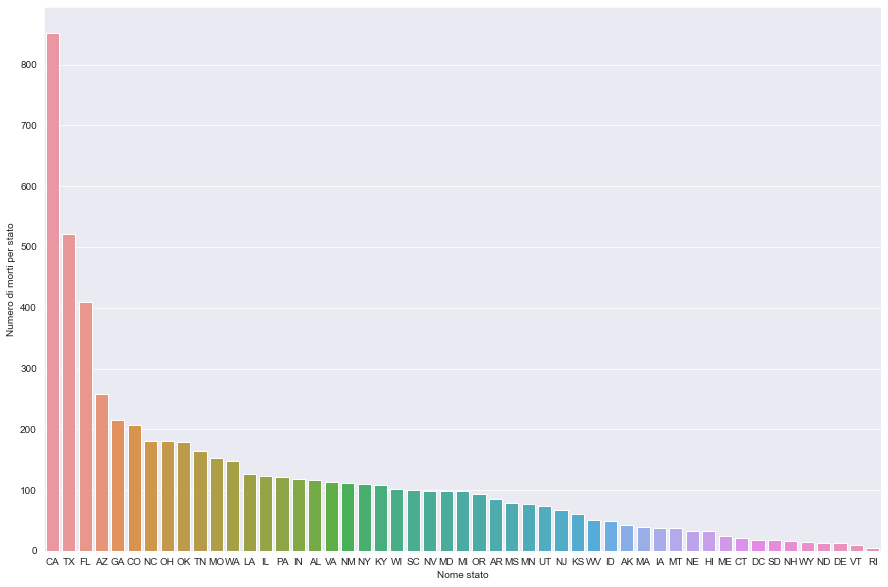

In [34]:
plt.figure(figsize=(15, 10))
k = df_all.sort_values(by=["dead"], axis=0, ascending=False)
sns.barplot(x="state", y="dead", data=k)
plt.xlabel('Nome stato')
plt.ylabel('Numero di morti per stato')

Text(0, 0.5, '% di donne morte nelle sparatorie (0.0 - 1)')

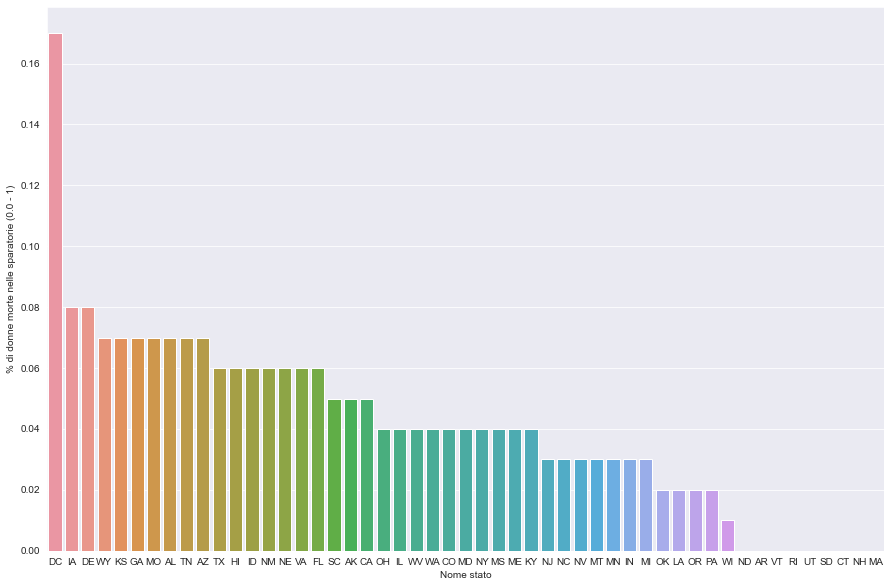

In [35]:
plt.figure(figsize=(15, 10))
k2 = df_all.sort_values(by=["gender_F"], axis=0, ascending=False)
sns.barplot(x="state", y="gender_F", data=k2)
plt.xlabel('Nome stato')
plt.ylabel('% di donne morte nelle sparatorie (0.0 - 1)')

Text(0, 0.5, '% di uomini morti nelle sparatorie (0.0 - 1)')

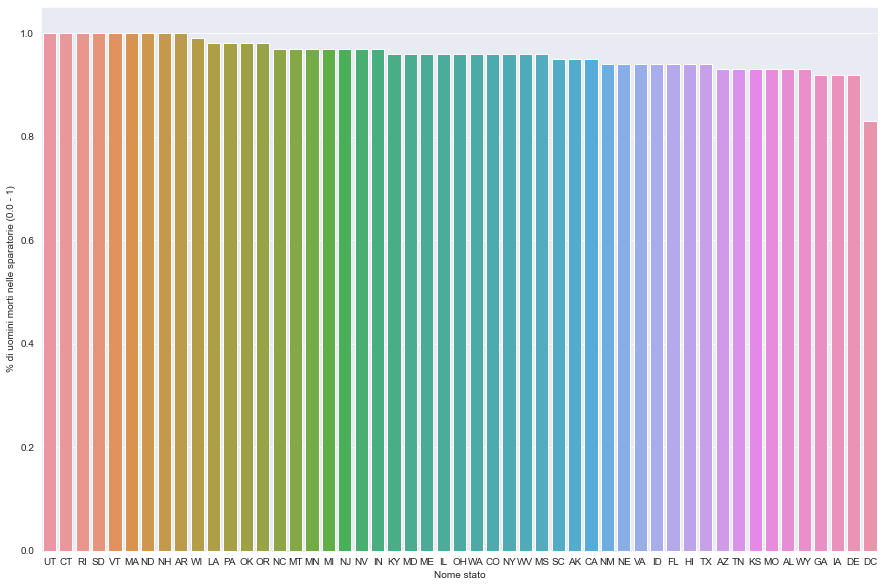

In [36]:
plt.figure(figsize=(15, 10))
k3 = df_all.sort_values(by=["gender_M"], axis=0, ascending=False)
sns.barplot(x="state", y="gender_M", data=k3)
plt.xlabel('Nome stato')
plt.ylabel('% di uomini morti nelle sparatorie (0.0 - 1)')

In [37]:
# Creo una mappa
m1 = folium.Map(location=[48, -102], zoom_start=3)
# Aggiungo un layer heatmap per indicare gli hotspot
plugins.HeatMap(data=hm,
                gradient=None,
                name="Heat map",
                min_opacity=1,
                radius=3,
                show=False,
                control=True,
                overlay=True,
                blur=4.5).add_to(m1)
# Invoco la funzione che crea le mappe tematiche
choroplet_generator(df_all, "dead", m1, "Morti per stato",
                    "Numero di morti per stato (dal 2015 al 2022)", "OrRd", 9)

choroplet_generator(df_all, "gender_F", m1, "Donne",
                    "% di donne morte per stato (dal 2015 al 2022)", "Purples",
                    9)

choroplet_generator(df_all, "gender_M", m1, "Uomini",
                    "% di uomini morti per stato (dal 2015 al 2022)", "Blues",
                    9)
# Aggiungo un toggle per attivate e disattivare i vari layer delle mappe tematiche
folium.LayerControl().add_to(m1)
m1

Dai grafici precedenti possiamo comprendere come la maggior parte delle vittime siano uomini.

## Età delle vittime

Text(0, 0.5, 'Età')

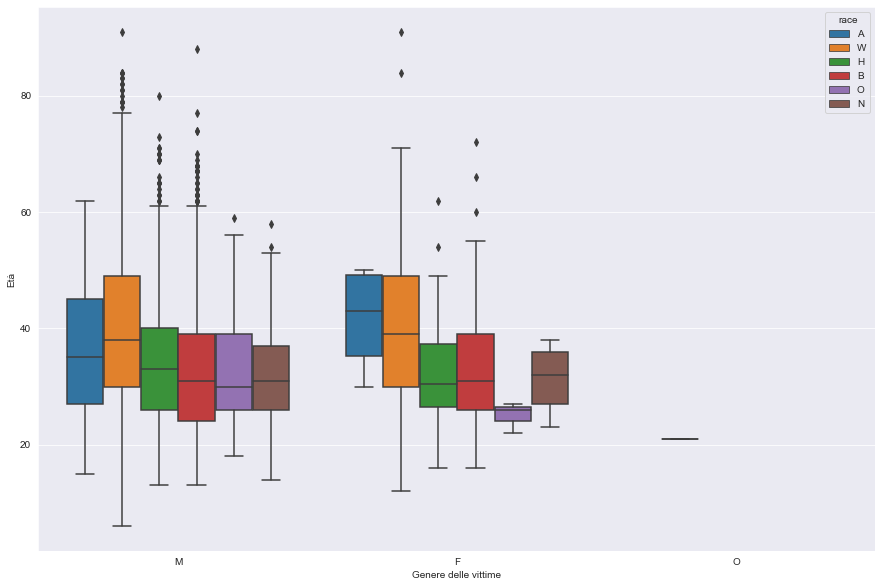

In [38]:
plt.figure(figsize=(15, 10))
sns.boxplot(x="gender", y="age", hue="race", data=df)
plt.xlabel('Genere delle vittime')
plt.ylabel('Età')

Da questo grafico possiamo notare delle particolarità:

1) I neri (sia maschi che femmine) che sono morti nelle sparatorie almeno il 75% di loro ha un'età < di 40 anni.

2) Tra le vittime nere notiamo una grande presenza di outliers, persone con età troppo al di fuori del range osservato (es. delle persone sono morte e avevano un'età >> di 40 anni.)

3) L'etnia che presenta dati più variegati è quella dei bianchi, infatti notiamo che le code dei boxplot sono molto lunghe e la IQR (differenza interquantile) è più ampia rispetto alle altre etnie. 

## Indicatori di povertà

In [39]:
# Funzione utile per creare una maschera per rappresentare meglio le heatmap di correlazione
def corr_triangle(dt):
    mask = np.zeros_like(dt)
    trinangle_indeces = np.triu_indices_from(mask)
    mask[trinangle_indeces] = True
    return (mask)

In [40]:
# Ho creato una funzione che mi aiuti a calcolare il coefficiente di regressione tra 2 colonne di un dataframe
def corr_coeff_2col(df, x, y):
    # Calcolo le medie delle due colonne
    x_mean = df[x].mean()
    y_mean = df[y].mean()
    # Calcolo la deviazione standard
    x_std = df[x].std()
    y_std = df[y].std()
    # Standardizzazione
    total_prod = (((df[x] - x_mean) / x_std) *
                  (((df[y] - y_mean) / y_std))).sum()
    corr = total_prod / (df.shape[0] - 1)
    return corr

In [41]:
# Ho creato una funzione che utilizza il calcolo combinatorio per rappresentare graficamente i dati
# Ciò è utilile per verificare i dati forniti dalla correlazione poichè è possibile che si presentino dei pattern
def corr_graph_check(col_list, data_df):
    k = list(combinations(col_list, 2))
    for col in k:
        sns.jointplot(x=data_df[col[0]],
                      y=data_df[col[1]],
                      kind="reg",
                      data=data_df)
        plt.show()

In [42]:
ls = ["poverty_rate", "percent_completed_hs", "median_household_income"]
ls1 = []
for idx in range(len(ls)):
    ls1.append(df_all.sort_values(by=str(ls[idx]), axis=0, ascending=False))

Text(0, 0.5, '% di persone sotto il grado di povertà (0 - 100)')

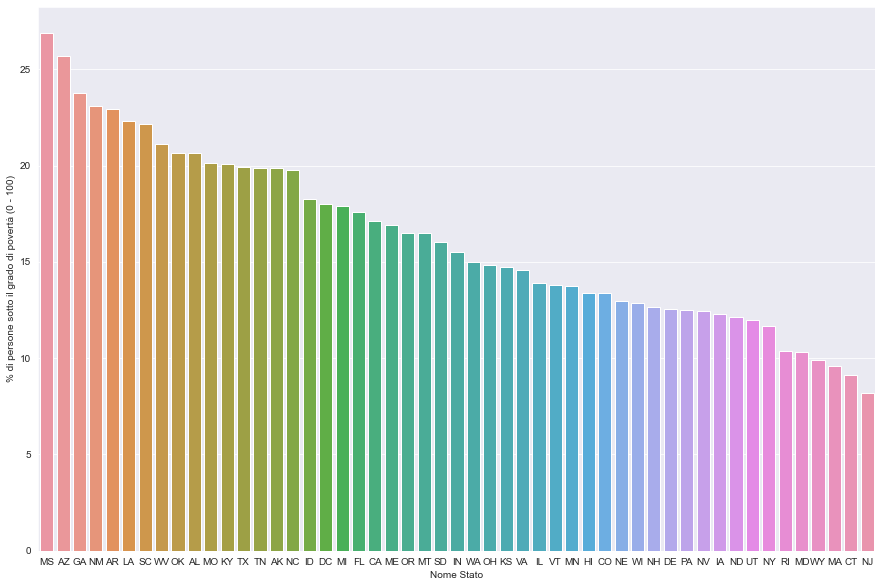

In [43]:
plt.figure(figsize=(15, 10))
sns.barplot(x="state", y=ls[0], data=ls1[0])
plt.xlabel('Nome Stato')
plt.ylabel('% di persone sotto il grado di povertà (0 - 100)')

Text(0, 0.5, '% di persone che ha completato le scuole superiori (0 - 100)')

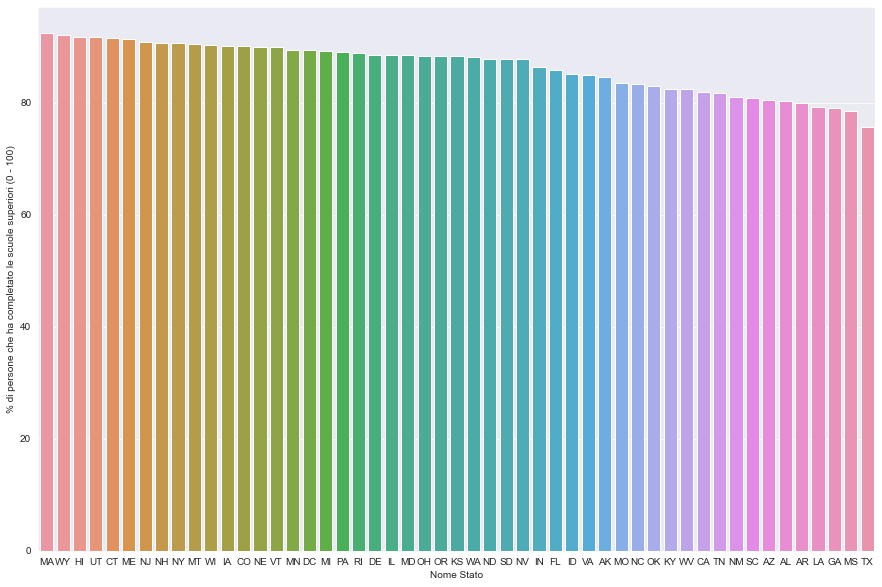

In [44]:
plt.figure(figsize=(15, 10))
sns.barplot(x="state", y=ls[1], data=ls1[1])
plt.xlabel('Nome Stato')
plt.ylabel('% di persone che ha completato le scuole superiori (0 - 100)')

Text(0, 0.5, 'Reddito medio annuale per famiglia ($)')

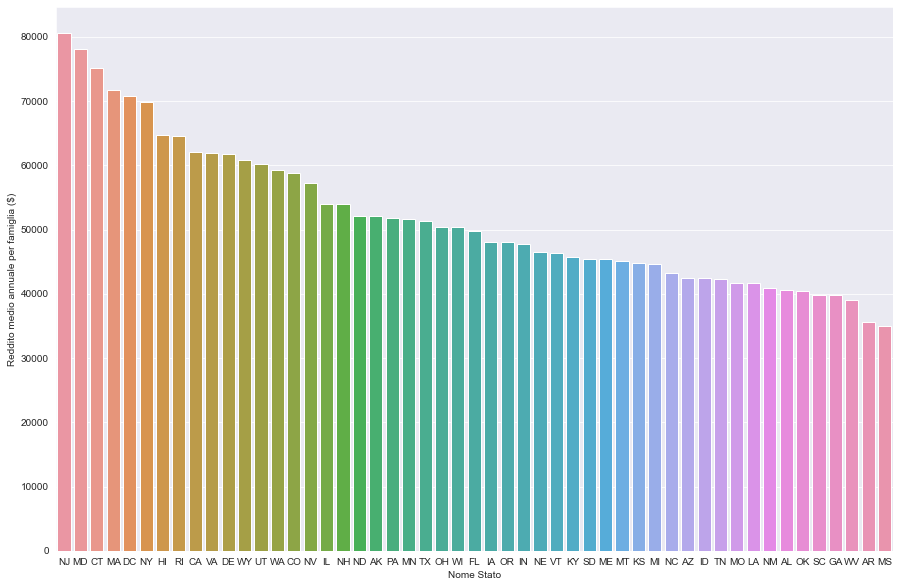

In [45]:
plt.figure(figsize=(15, 10))
sns.barplot(x="state", y=ls[2], data=ls1[2])
plt.xlabel('Nome Stato')
plt.ylabel('Reddito medio annuale per famiglia ($)')

In [46]:
# Creo una mappa
m2 = folium.Map(location=[48, -102], zoom_start=3)
# Invoco la funzione che crea le mappe tematiche
choroplet_generator(df_all, ls[0], m2, "Povertà per stato",
                    "% di persone sotto il grado di povertà", "OrRd", 9)
choroplet_generator(df_all, ls[1], m2, "Grado di istruzione",
                    "% di persone che hanno completato le scuole superiori",
                    "RdYlGn", 9)
choroplet_generator(df_all, ls[2], m2, "Reddito medio",
                    "Reddito medio annuo per famiglia", "RdYlGn", 6)
# Aggiungo un toggle per attivate e disattivare i vari layer delle mappe tematiche
folium.LayerControl().add_to(m2)
m2

Possiamo constatare come la ricchezza e il grado di istruzione sembrerebbero correlati tra loro, infatti gli stati più ricchi sembrerebbero anche quelli più istruiti e tendenzialmente sono quelli del nord est.

Infatti notiamo che l'indicatore di povertà potrebbe presentare un valore della correlazione negativa siccome diminuisce negli stati più ricchi.

<AxesSubplot:>

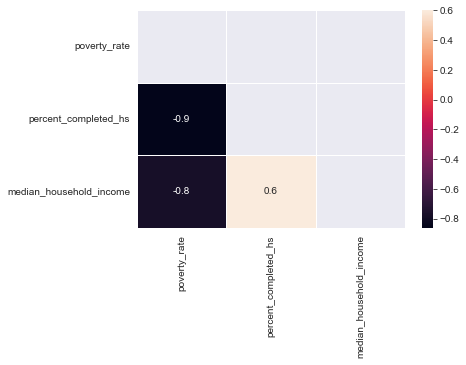

In [47]:
data1 = df_all[[ls[0], ls[1], ls[2]]].corr()
sns.heatmap(data1,
            annot=True,
            mask=corr_triangle(data1),
            linewidths=0.5,
            linecolor="white",
            fmt='.1f')

Notiamo infatti che, come ipotizzato precedentemente, l'indice di povertà presenta un fattore di dipendenza in media negativo molto forte nei confronti di: il reddito medio annuo per famiglia e la % di persone che hanno compretato le scuole superiori.

Ciò significa che all'aumentare del tasso di povertà diminuise il reddito medio annuo e la % di persone che ha completato le scuole superiori.

Al contrario notiamo come il reddito medio sia correlato positivamente con la % di persone che hanno completato le scuole superiori.

Questi dati confermano la nostra tesi, infatti a maggior grado di istruzione corrisponde una maggiore ricchezza.

0.28

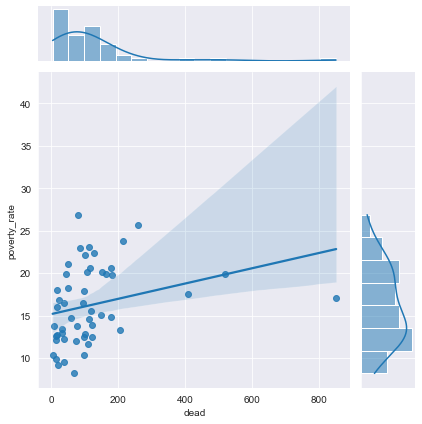

In [48]:
sns.jointplot(x="dead", y="poverty_rate", kind="reg", data=df_all)
corr_coeff_2col(df_all, "dead", "poverty_rate").round(2)

Il grafico mostra una possibile correlazione positiva tra numero di morti per stato e indice di povertà.

All'aumentare dell'indice di povertà sembrerebbe aumentare anche il numero di morti.

Notiamo infatti che si tratta di un valore > 0.

0.0

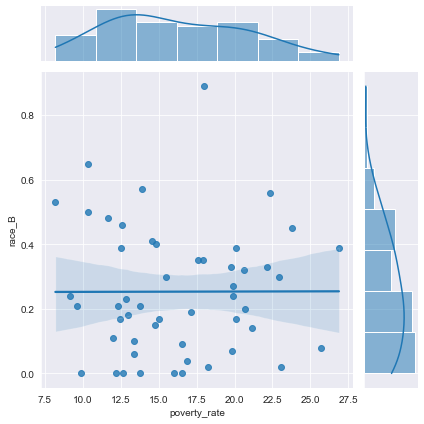

In [49]:
sns.jointplot(x="poverty_rate", y="race_B", kind="reg", data=df_all)
corr_coeff_2col(df_all, "poverty_rate", "race_B").round(2)

Si comprende che vi è indipendenza tra il tasso di povertà e la % di neri uccisi.

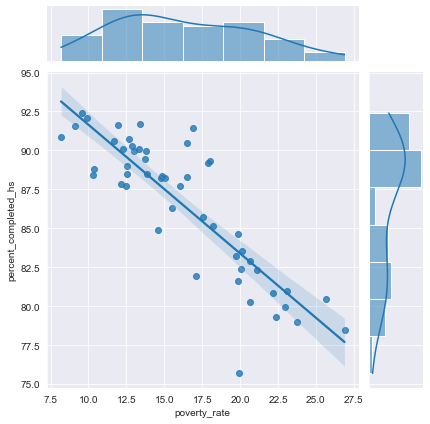

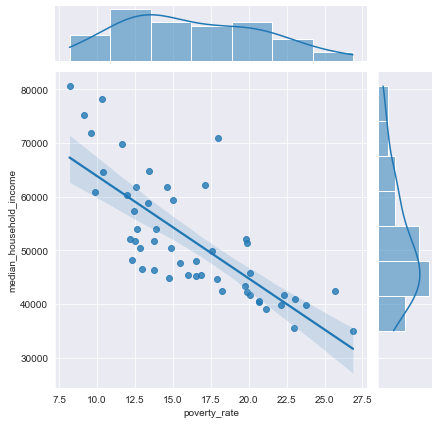

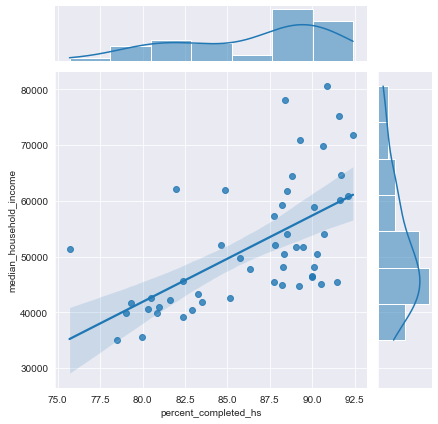

In [50]:
corr_graph_check(ls, df_all)

La creazione di questi grafici è propedeutica allo studio della correlazione, infatti sono stati creati per indagare il comportamento della retta di correlazione.

## Distribuzione etnie

In [51]:
ls2 = ["share_white", "share_black", "share_native_american", "share_asian"]
# Creo una mappa
m3 = folium.Map(location=[48, -102], zoom_start=3)
# Invoco la funzione che crea le mappe tematiche
for val in ls2:
    choroplet_generator(df_all, str(val), m3, str(val),
                        f"% di {val} per singolo stato", "Blues", 9)
# Aggiungo un toggle per attivate e disattivare i vari layer delle mappe tematiche
folium.LayerControl().add_to(m3)
m3

Notiamo immediatamente come vi sia una differenza tra la distribuzione delle etnie dal punto di vista geografico.

Infatti i bianchi sono maggiormente collocati a nord degli stati uniti ( zone tendenzialmente più benestatnti) mentre i neri si trovano maggiormente negli stati del sud ( stati con idicatori di povertà generalmente pù alti).

Perciò ritengo siano presenti i presupposti per effettuare uno studio di correlazione su questi dati.

In [52]:
ls3 = ["race_W", "race_B", "race_N", "race_A", "race_H"]
# Creo una mappa
m4 = folium.Map(location=[48, -102], zoom_start=3)
# Invoco la funzione che crea le mappe tematiche
for val in ls3:
    choroplet_generator(df_all, str(val), m4, str(val),
                        f"% di {val} morti per singolo stato (0.0 - 1)",
                        "Greys", 9)
# Aggiungo un toggle per attivate e disattivare i vari layer delle mappe tematiche
folium.LayerControl().add_to(m4)
m4

Questo grafico ci permette di comprendere come sono distribuite le morti dal punto di vista geografico.

<AxesSubplot:>

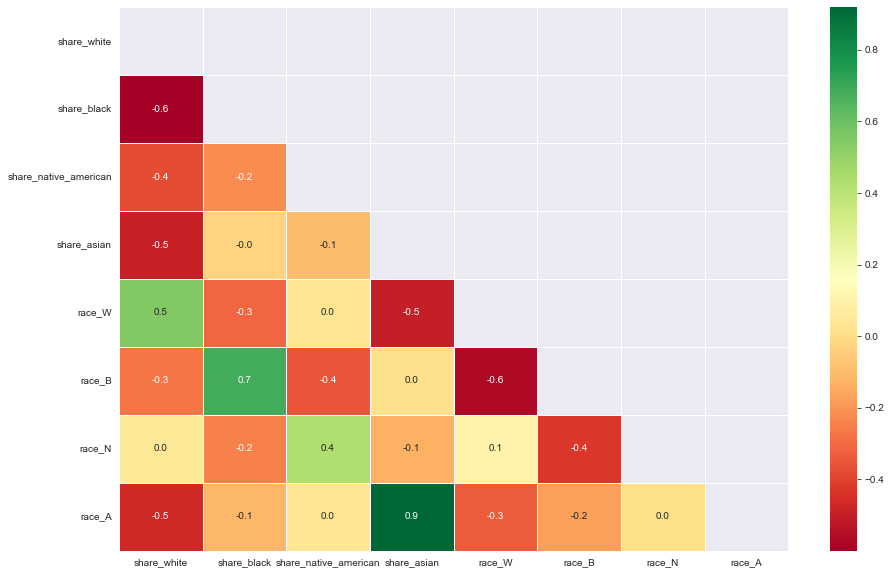

In [53]:
plt.figure(figsize=(15, 10))
data2 = df_all[[
    ls2[0], ls2[1], ls2[2], ls2[3], ls3[0], ls3[1], ls3[2], ls3[3]
]]
sns.heatmap(data2.corr(),
            mask=corr_triangle(data2.corr()),
            cmap="RdYlGn",
            annot=True,
            linewidths=0.5,
            linecolor="white",
            fmt='.1f')

Da questo grafico possiamo comprendere come il numero di morti di una certa etnia dipenda in media dal numero di persone di quella stessa etnia che vivono nello stato.

Esempio:
Il numero di neri uccisi dalla polizzia aumenta all'aumentari di neri che abitano in un determinato stato.

In [54]:
# Questa sezione di codice è stata disattivata poichè è utile solo come controllo e non ha scopo illustrativo
#corr_graph_check(data2.columns.unique(), data2)

## Distribuzione ricchezza tra etnie

<AxesSubplot:>

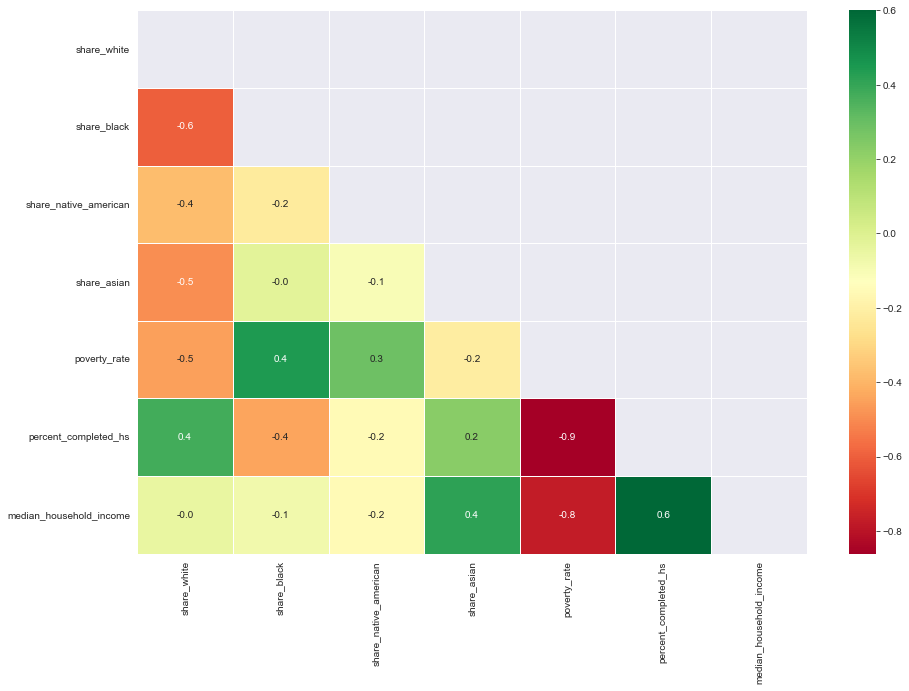

In [55]:
plt.figure(figsize=(15, 10))
data3 = df_all[[ls2[0], ls2[1], ls2[2], ls2[3], ls[0], ls[1], ls[2]]]
sns.heatmap(data3.corr(),
            mask=(corr_triangle(data3.corr())),
            cmap="RdYlGn",
            annot=True,
            linewidths=0.5,
            linecolor="white",
            fmt='.1f')

Qui invece notiamo come la ricchezza si principalmente detenuta dall'etnia bianca e in piccola parte asiatica, mentre i neri e nativi americani siano i gruppi sociali con più difficoltà.

Un dato interessante è quello che il reddito medio annuo dipenda poco o quasi nulla dal numero di persone di una determinata etnia che abitano la stessa zona, tranne nel caso di persone di origine asiatica.

In [56]:
# Questa sezione di codice è stata disattivata poichè è utile solo come controllo e non ha scopo illustrativo
#corr_graph_check(data3.columns.unique(), data3)

## Distribuzione malattie mentali

In [57]:
# Creo una mappa
m5 = folium.Map(location=[48, -102], zoom_start=3)
# Invoco la funzione che crea le mappe tematiche
choroplet_generator(
    df_all, "signs_of_mental_illness_True", m5, "Malattie mentali",
    "% di persone con malettie mentali che sono state uccise per stato (0.0 - 1)",
    "PuRd", 9)
# Aggiungo un toggle per attivate e disattivare i vari layer delle mappe tematiche
folium.LayerControl().add_to(m5)
m5

Il grafico in questione ci permette di visualizzare come varia la % di casi in cui la persona che è stata uccisa dalla polizzia soffrisse di malattie mentali.

<!-- E' interessante notare che si ha una maggior % di casi quando ci si sposta verso il nord degli stati uniti. -->

<AxesSubplot:>

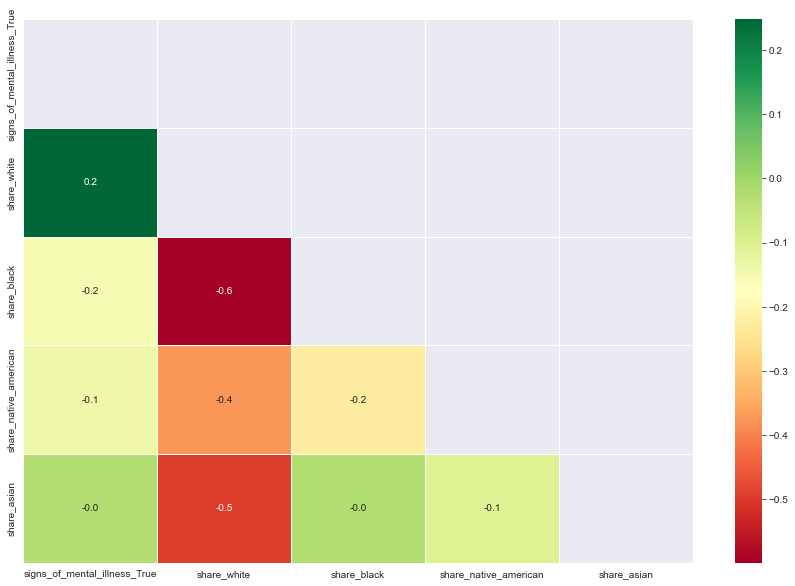

In [58]:
plt.figure(figsize=(15, 10))
data4 = df_all[[
    "signs_of_mental_illness_True", ls2[0], ls2[1], ls2[2], ls2[3]
]]
sns.heatmap(data4.corr(),
            mask=(corr_triangle(data4.corr())),
            cmap="RdYlGn",
            annot=True,
            linewidths=0.5,
            linecolor="white",
            fmt='.1f')

Questo grafico ci mostra come il numero di casi di malattie mentali dipenda in piccola parte dalla quantità di bianchi in uno stato.

<AxesSubplot:>

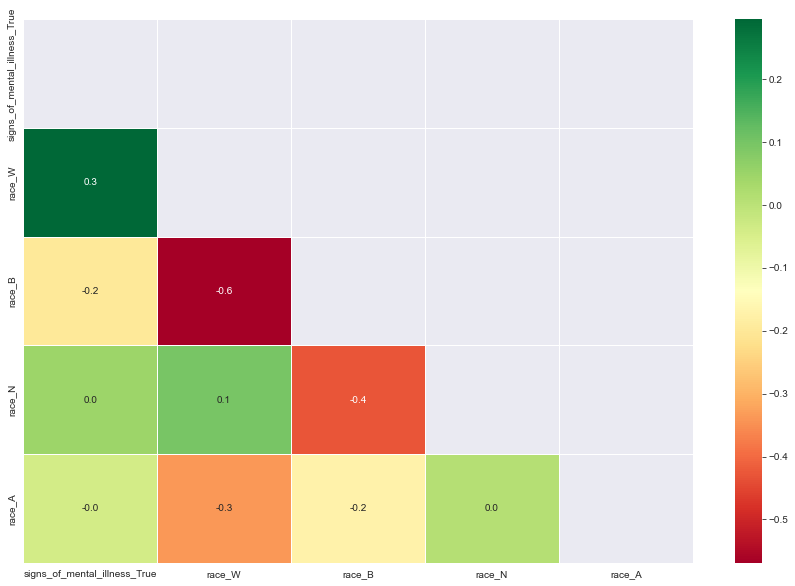

In [59]:
plt.figure(figsize=(15, 10))
data5 = df_all[[
    "signs_of_mental_illness_True", ls3[0], ls3[1], ls3[2], ls3[3]
]]
sns.heatmap(data5.corr(),
            mask=(corr_triangle(data5.corr())),
            cmap="RdYlGn",
            annot=True,
            linewidths=0.5,
            linecolor="white",
            fmt='.1f')

0.32

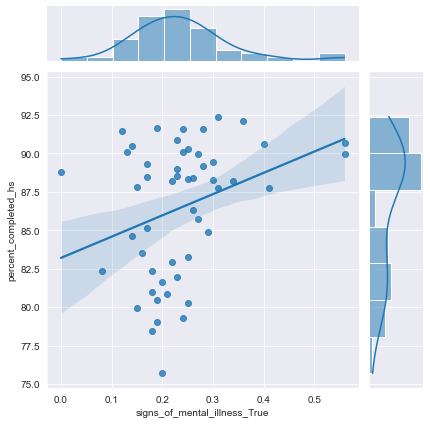

In [60]:
sns.jointplot(x=df_all["signs_of_mental_illness_True"],
              y=df_all[ls[1]],
              kind="reg",
              data=df_all)
corr_coeff_2col(df_all, "signs_of_mental_illness_True",
                "percent_completed_hs").round(2)

-0.32

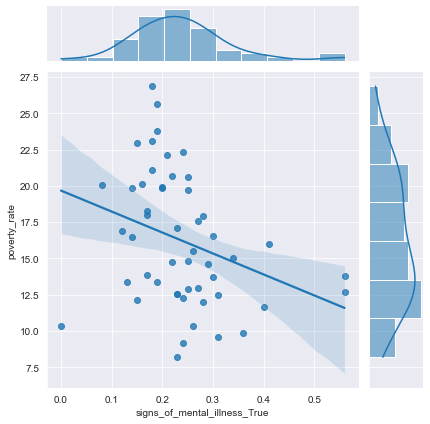

In [61]:
sns.jointplot(x=df_all["signs_of_mental_illness_True"],
              y=df_all[ls[0]],
              kind="reg",
              data=df_all)
corr_coeff_2col(df_all, "signs_of_mental_illness_True",
                "poverty_rate").round(2)

Vi è una leggera dipendenza in media tra la % di omicidi di persone che soffrivano di malattie mentali e il numero di bianchi residenti in uno stato, mentre questo rapporto è negativo per le persone nere.

## Indicatori di pericolo

In [62]:
# Creo una mappa
m6 = folium.Map(location=[48, -102], zoom_start=3)
# Invoco la funzione che crea le mappe tematiche
choroplet_generator(df_all, "threat_level_attack", m6, "Attacco diretto",
                    "% di casi di attacchi diretti ai polizziotti (0.0 - 1)",
                    "Reds", 9)
choroplet_generator(
    df_all, "threat_level_other", m6, "Attacco indiretto",
    "% di casi di attacchi indiretti ai polizziotti (0.0 - 1)", "Oranges", 9)
# Aggiungo un toggle per attivate e disattivare i vari layer delle mappe tematiche
folium.LayerControl().add_to(m6)
m6

0.28

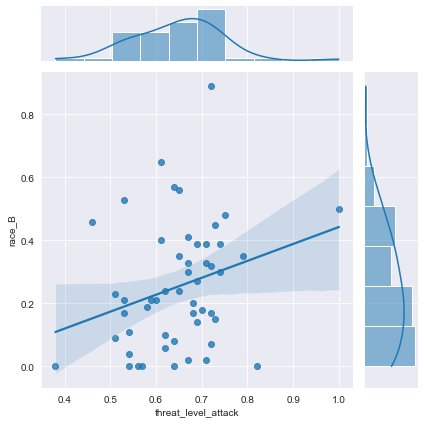

In [63]:
sns.jointplot(x="threat_level_attack", y="race_B", kind="reg", data=df_all)
corr_coeff_2col(df_all, "threat_level_attack", "race_B").round(2)

-0.25

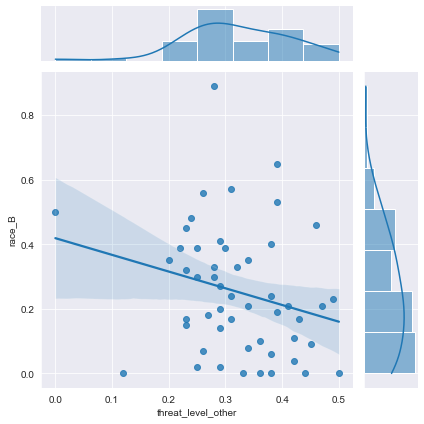

In [64]:
sns.jointplot(x="threat_level_other", y="race_B", kind="reg", data=df_all)
corr_coeff_2col(df_all, "threat_level_other", "race_B").round(2)

Dai grafici sembrerebbe che all'aumentare delle persone nere morte ci sia stato un maggior numero di polizziotti che hanno sparato perchè sentendosi direttamente minacciati dalla vittima. 

-0.23

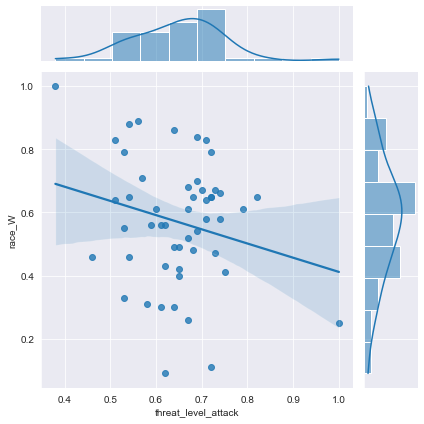

In [65]:
sns.jointplot(x="threat_level_attack", y="race_W", kind="reg", data=df_all)
corr_coeff_2col(df_all, "threat_level_attack", "race_W").round(2)

Infatti se notiamo lo stesso parametro calcolato su persone di colore bianco è minore, ciò potrebbe significare che le forze dell'ordine vedano le persone nere un un pericolo maggiore rispetto alle bianche.

# Conclusioni
Dallo studio abbiamo appreso in America circa 7451 persone hanno perso la vita tra il 2015 e 2022 a causa delle forze dell' ordine.

L'età media delle vittime era di 36 anni. 

Il 95% di queste vittime erano uomini e il 5% donne.

Il 57% delle vittime era di etnia bianca, 25% di origine nera, 12% ispaniche, 4% di origine nativa americana e 2% asiatica.

I bianchi occupano upresentano una fetta maggiore di popolazione sul suolo statunitense rispetto alle altre etnie, la concentrazione massima la si ha negli stati del nord est, mentre per i neri gli stati con maggiore concentrazione sono quelli del sud est.

Dai dati risulta inoltre che i bianchi e asiatici detengano molta più ricchezza rispetto ai neri e nativi americani, quest'ultima si manifesta in salari medi annui e tassi d'istruzione più alti, poiche la ricchezza è positivamente correlata a quest'altri dati.

Dato saliente è che il numero di morti aumenta all'aumentare del tasso di povertà, infatti i due dati sono direttamente correlati tra loro con valore 0.28 MA non si ha dipendenza tra il tasso di povertà e omicidi di persone nere.

Vi è una leggera dipendenza in media tra la % di omicidi di persone che soffrivano di malattie mentali e il numero di bianchi residenti in uno stato, mentre questo rapporto è negativo per le persone nere.

Esiste una leggera correlazione tra il numero di neri morti per stato e la % di casi in cui i polizziotti si sentivano particolarmente a rischio. (Questo dato potrebbe essere un indicatore della discriminazione da parte della polizia nei confronti dei neri)